In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/huy/

/content/drive/MyDrive/huy


In [7]:
!unzip "data.zip"

Archive:  data.zip
  inflating: data_actinh.pkl         
  inflating: data_valid.pkl          
  inflating: data_lanhtinh.pkl       
  inflating: data_train.pkl          


In [3]:
INIT_LR = 1e-4
NUM_EPOCHS = 150
BATCH_SIZE = 32

In [4]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img
import imutils
from google.colab.patches import cv2_imshow

In [5]:
with open('/content/drive/MyDrive/huy/data_actinh.pkl', 'rb') as f:
  imgsActinh,labelsActinh,boxesActinh=pickle.load(f)
f.close()

In [6]:
with open('/content/drive/MyDrive/huy/data_lanhtinh.pkl', 'rb') as f:
  imgsLanhtinh,labelsLanhtinh,boxesLanhtinh=pickle.load(f)
f.close()

In [7]:
labelsLanhtinh=np.expand_dims(labelsLanhtinh,1)
labelsActinh=np.expand_dims(labelsActinh,1)

In [8]:
imgs=np.concatenate((imgsActinh, imgsLanhtinh), axis=0)
labels=np.concatenate((labelsActinh, labelsLanhtinh), axis=0)
boxes=np.concatenate((boxesActinh, boxesLanhtinh), axis=0)

In [9]:
new_labels = to_categorical(labels,num_classes=2)

In [10]:
Itrain,Itest,Ltrain,Ltest,Btrain,Btest=train_test_split(imgs, new_labels, boxes,test_size=0.2, random_state=42)

In [11]:
with open('/content/drive/MyDrive/huy/data_train.pkl', 'rb') as f:
  trainImages,trainLabels,trainBBoxes=pickle.load(f)
f.close()
with open('/content/drive/MyDrive/huy/data_valid.pkl', 'rb') as f:
  testImages,testLabels,testBBoxes=pickle.load(f)
f.close()

In [12]:
trainImages=np.concatenate((trainImages, Itrain), axis=0)
trainBBoxes=np.concatenate((trainBBoxes, Btrain), axis=0)
trainLabels=np.concatenate((trainLabels, Ltrain), axis=0)
testImages=np.concatenate((testImages, Itest), axis=0)
testBBoxes=np.concatenate((testBBoxes, Btest), axis=0)
testLabels=np.concatenate((testLabels, Ltest), axis=0)

In [13]:
trainImages.shape,trainBBoxes.shape,trainLabels.shape

((3168, 224, 224, 3), (3168, 4), (3168, 2))

In [14]:
mobileNet = ResNet152(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
mobileNet.trainable = False
flatten = mobileNet.output
flatten = Flatten()(flatten)
bboxHead = Dense(64, activation="relu")(flatten)
bboxHead = Dropout(0.25)(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dropout(0.25)(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)
softmaxHead = Dense(64, activation="relu")(flatten)
softmaxHead = Dropout(0.25)(softmaxHead)
softmaxHead = Dense(32, activation="relu")(softmaxHead)
softmaxHead = Dense(2, activation="softmax",name="class_label")(softmaxHead)
model = Model(inputs=mobileNet.input,outputs=(bboxHead, softmaxHead))

234708992/234698864 [==============================] - 2s 0us/step


In [ ]:
import tensorflow as tf
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mse",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
model.summary()

In [16]:
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [17]:
NUM_EPOCHS

150

In [18]:
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)
print("[INFO] saving object detector model...")
model.save('/content/drive/MyDrive/huy/resnet152_150epoch.h5', save_format="h5")

[INFO] training model...
Epoch 1/150
50/50 [==============================] - 42s 372ms/step - loss: 0.7634 - bounding_box_loss: 0.0456 - class_label_loss: 0.7178 - bounding_box_accuracy: 0.5271 - class_label_accuracy: 0.5417 - val_loss: 0.7199 - val_bounding_box_loss: 0.0206 - val_class_label_loss: 0.6993 - val_bounding_box_accuracy: 0.5997 - val_class_label_accuracy: 0.4937
Epoch 2/150
50/50 [==============================] - 15s 303ms/step - loss: 0.7131 - bounding_box_loss: 0.0360 - class_label_loss: 0.6771 - bounding_box_accuracy: 0.5388 - class_label_accuracy: 0.5723 - val_loss: 0.7103 - val_bounding_box_loss: 0.0191 - val_class_label_loss: 0.6912 - val_bounding_box_accuracy: 0.5997 - val_class_label_accuracy: 0.5164
Epoch 3/150
50/50 [==============================] - 15s 302ms/step - loss: 0.7072 - bounding_box_loss: 0.0324 - class_label_loss: 0.6748 - bounding_box_accuracy: 0.5407 - class_label_accuracy: 0.5900 - val_loss: 0.6787 - val_bounding_box_loss: 0.0163 - val_class_lab

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


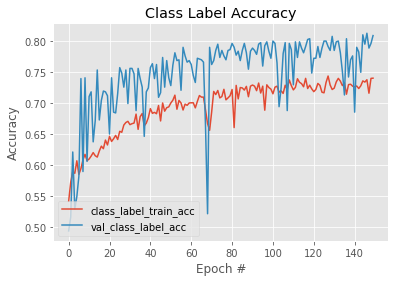

In [19]:
N=np.arange(0,NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plt.savefig('/content/drive/MyDrive/huy/acc_ResNet152.png')

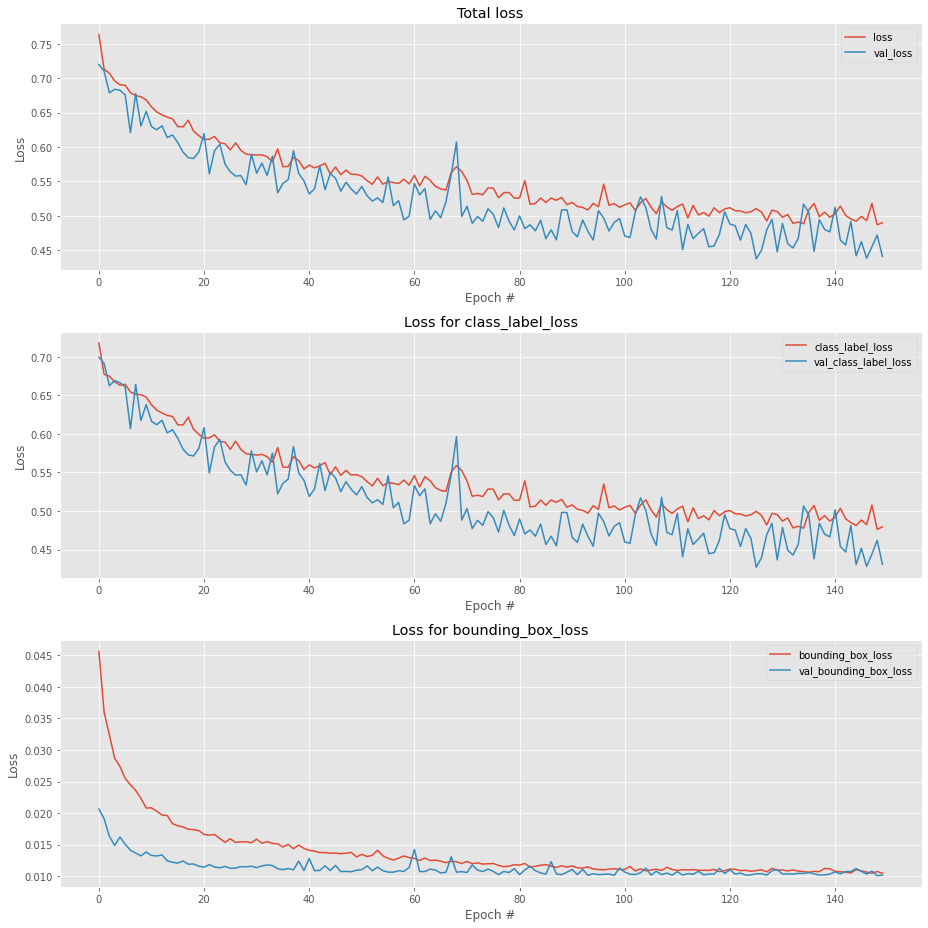

In [20]:
lossNames = ["loss","class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/huy/losses_ResNet152.png')
plt.close()

In [ ]:
lb = pickle.loads(open('/content/drive/MyDrive/Deep/output/lb.pkl', "rb").read())
#my_file = open("/content/drive/MyDrive/Deep/output/test.txt", "r")
#imagePaths = my_file.readlines()

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Deep/output/resnet152_finetuning.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,"models")

In [ ]:
''' link=imagePaths[7].rstrip()
print(link) '''
img = load_img('/content/drive/MyDrive/Deep/test/lanhtinh/ISIC_0024446.jpg', target_size=(224, 224))
image = img_to_array(img) / 255.0
image = np.expand_dims(image, axis=0)
(boxPreds, labelPreds) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
i = np.argmax(labelPreds, axis=1)
label = lb.classes_[i][0]

In [ ]:
print(label)

actinh


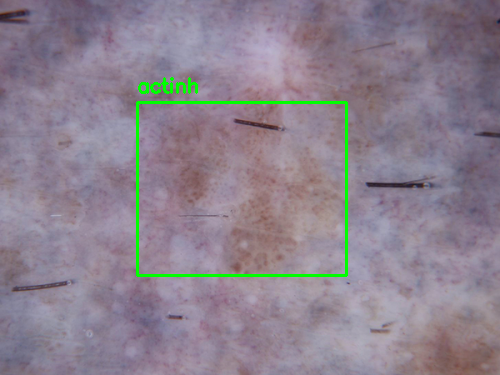

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Deep/test/lanhtinh/ISIC_0024446.jpg')
image = imutils.resize(image, width=500)
(h, w) = image.shape[:2]
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
y = startY - 10 if startY - 10 > 10 else startY + 10
cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
cv2_imshow(image)